<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
# !pip install -U stable-baselines3==2.3.0 sb3-contrib==2.3.0

Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0
  Attempting uninstall: stable-baselines3
    Found existing installation: stable_baselines3 2.7.0
    Uninstalling stable_baselines3-2.7.0:
      Successfully uninstalled stable_baselines3-2.7.0


In [3]:
import stable_baselines3, sb3_contrib
print("SB3 version:", stable_baselines3.__version__)
print("SB3-Contrib version:", sb3_contrib.__version__)

SB3 version: 2.3.0
SB3-Contrib version: 2.3.0


In [50]:
from collections import deque
import numpy as np
import gymnasium as gym

class RiskMetric:
    SHARPE = "sharpe"
    SORTINO = "sortino"
    PNL = "pnl"

class RiskRewardWrapper(gym.Wrapper):
    def __init__(self, env, risk_metric=RiskMetric.SHARPE, window=20, annualization=252.0, scale=1.0):
        super().__init__(env)
        self.risk_metric = risk_metric
        self.window = window
        self.annualization = annualization
        self.scale = scale
        self._returns = deque(maxlen=window)
        self._last_value = None
        self.eps = 1e-8

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self._returns.clear()
        self._last_value = self._portfolio_value()
        return obs, info

    def step(self, action):
        obs, reward, done, trunc, info = self.env.step(action)
        current_val = self._portfolio_value()
        ret = (current_val - self._last_value) / (self._last_value + self.eps)
        self._last_value = current_val
        self._returns.append(ret)

        if self.risk_metric == RiskMetric.PNL or len(self._returns) < 2:
            shaped = ret
        elif self.risk_metric == RiskMetric.SHARPE:
            mean, std = np.mean(self._returns), np.std(self._returns) + self.eps
            shaped = (mean / std) * np.sqrt(self.annualization)
        elif self.risk_metric == RiskMetric.SORTINO:
            mean = np.mean(self._returns)
            downside = np.std([r for r in self._returns if r < 0] or [0.0]) + self.eps
            shaped = (mean / downside) * np.sqrt(self.annualization)

        return obs, shaped * self.scale, done, trunc, info

    def _portfolio_value(self):
        state = self.env.state
        stock_dim = self.env.stock_dim
        prices = np.array(state[1:1 + stock_dim])
        shares = np.array(state[1 + stock_dim:1 + 2 * stock_dim])
        return float(state[0] + (prices * shares).sum())



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint


import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'

In [7]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2023-10-01'

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TRADE_END_DATE,
                    ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
# yfp = YahooFinanceProcessor()
# df = yfp.download_data(['AXP', 'AMGN', 'AAPL'], '2010-01-01', '2010-02-01', '1m')
print(df)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (112073, 8)
Price         date       close        high         low        open     volume  \
0       2010-01-04    6.431896    6.446623    6.382908    6.414465  493729600   
1       2010-01-04   39.913258   40.016981   39.111120   39.159525    5277400   
2       2010-01-04   32.637962   32.781531   32.215233   32.550228    6894300   
3       2010-01-04   43.777550   43.941189   42.702201   43.419101    6186700   
4       2010-01-04   39.403469   39.834181   38.703561   38.797781    7325600   
...            ...         ...         ...         ...         ...        ...   
112068  2025-02-28  469.605164  470.989374  459.243337  461.734915    6146300   
112069  2025-02-28  362.108612  363.396482  353.123534  354.121876   15857300   
112070  2025-02-28   41.743721   42.382952   41.269142   42.063338   25197500   
112071  2025-02-28   10.680000   11.490000   10.480000   10.630000   52407400   
112072  2025-02-28   98.102753   98.351467   96.670158   97.286971   2545130

In [9]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [10]:
df.shape

(112073, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600,AAPL,0
1,2010-01-04,39.913258,40.016981,39.111120,39.159525,5277400,AMGN,0
2,2010-01-04,32.637962,32.781531,32.215233,32.550228,6894300,AXP,0
3,2010-01-04,43.777550,43.941189,42.702201,43.419101,6186700,BA,0
4,2010-01-04,39.403469,39.834181,38.703561,38.797781,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3812, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
print(processed)

              date       close        high         low        open     volume  \
0       2010-01-04    6.431896    6.446623    6.382908    6.414465  493729600   
1       2010-01-04   39.913258   40.016981   39.111120   39.159525    5277400   
2       2010-01-04   32.637962   32.781531   32.215233   32.550228    6894300   
3       2010-01-04   43.777550   43.941189   42.702201   43.419101    6186700   
4       2010-01-04   39.403469   39.834181   38.703561   38.797781    7325600   
...            ...         ...         ...         ...         ...        ...   
110543  2025-02-27  463.277313  470.040193  459.777216  460.914274    4216800   
110544  2025-02-27  355.150177  359.712607  351.096911  351.316547    7298100   
110545  2025-02-27   41.908375   42.053652   41.540332   41.724355   19212300   
110546  2025-02-27   11.230000   11.850000   11.190000   11.700000   18971100   
110547  2025-02-27   96.292122   97.535692   95.317160   95.406701   16431500   

         tic  day       mac

In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.431896,6.446623,6.382908,6.414465,493729600.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,6.431896,6.431896,20.040001,0.0
1,2010-01-04,AMGN,39.913258,40.016981,39.111120,39.159525,5277400.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,39.913258,39.913258,20.040001,0.0
2,2010-01-04,AXP,32.637962,32.781531,32.215233,32.550228,6894300.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,32.637962,32.637962,20.040001,0.0
3,2010-01-04,BA,43.777550,43.941189,42.702201,43.419101,6186700.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,43.777550,43.777550,20.040001,0.0
4,2010-01-04,CAT,39.403469,39.834181,38.703561,38.797781,7325600.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,39.403469,39.403469,20.040001,0.0
5,2010-01-04,CRM,18.542519,18.718477,18.386387,18.490475,7906000.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,18.542519,18.542519,20.040001,0.0
6,2010-01-04,CSCO,16.158165,16.256331,15.713144,15.778589,59853700.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,16.158165,16.158165,20.040001,0.0
7,2010-01-04,CVX,42.603539,42.678981,42.118553,42.140105,10173800.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,42.603539,42.603539,20.040001,0.0
8,2010-01-04,DIS,27.475882,28.058470,27.304533,27.844283,13700400.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,27.475882,27.475882,20.040001,0.0
9,2010-01-04,GS,131.992004,132.884253,129.269492,129.681306,9135000.0,0.0,0.0,6.453182,6.42173,100.0,66.666667,100.0,131.992004,131.992004,20.040001,0.0


In [16]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [17]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

100311
10237


In [18]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3458,2023-09-29,UNH,489.152222,494.672516,488.773839,494.643412,3006200.0,4.0,4.758832,499.945956,450.959732,55.148627,128.373470,19.202186,475.052340,477.039839,17.52,57.508067
3458,2023-09-29,V,227.020615,230.001369,226.665293,229.813836,6045200.0,4.0,-3.066165,251.200591,224.032601,41.887465,-154.263031,36.909202,238.148428,237.149245,17.52,57.508067
3458,2023-09-29,VZ,28.312366,28.609380,28.277423,28.495815,19787600.0,4.0,-0.276669,30.421856,28.184128,41.243805,-137.570285,33.867281,29.353076,29.363413,17.52,57.508067
3458,2023-09-29,WBA,20.083015,20.254588,18.854917,18.963279,25663400.0,4.0,-1.050146,20.962601,18.592987,36.119185,-53.011515,26.754695,20.958936,23.656805,17.52,57.508067
3458,2023-09-29,WMT,52.213680,53.258410,51.972083,53.225763,18842400.0,4.0,0.139827,54.153630,52.232609,50.578476,-24.941533,17.468286,52.741927,52.075983,17.52,57.508067


In [19]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.259903,172.805189,169.464080,169.751602,52164500.0,0.0,-2.561662,183.575465,165.836042,45.243151,-87.977341,26.128995,176.566327,181.009778,17.610001,34.480682
0,2023-10-02,AMGN,252.198273,254.262748,250.370550,253.524081,1912300.0,0.0,3.867162,261.151697,237.536329,59.425423,72.228451,31.542886,247.539642,237.412816,17.610001,34.480682
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052555,160.817408,143.761838,37.445494,-174.733337,36.526723,153.348370,158.819427,17.610001,34.480682
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480682
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878852,277.101116,259.928743,51.346803,-69.196893,1.038314,268.083488,264.021852,17.610001,34.480682


In [20]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}



## Environment for Training



In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_rppo_risk_env():
    base_env = StockTradingEnv(df=train, **env_kwargs)
    wrapped_env = RiskRewardWrapper(
        base_env,
        risk_metric="sharpe",
        window=63,
        annualization=252,
        scale=1.0
    )
    return wrapped_env

env_train = DummyVecEnv([make_rppo_risk_env])


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:

policy_kwargs = dict(
    lstm_hidden_size=256,
    n_lstm_layers=1,
    shared_lstm=True,
    enable_critic_lstm=False,
    net_arch=dict(pi=[128, 128], vf=[128, 128]),
    ortho_init=False
)

model_rppo_risk = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=env_train,
    learning_rate=1e-4,
    n_steps=4096,
    batch_size=512,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,
    max_grad_norm=0.5,
    tensorboard_log="./tensorboard_rppo_risk/",
    policy_kwargs=policy_kwargs,
    verbose=1
)

print("Starting RPPO-Risk training...")
model_rppo_risk.learn(total_timesteps=200_000)
model_rppo_risk.save("rppo_risk_sharpe")
print("RPPO-Risk training finished and model saved.")

Using cpu device
Starting RPPO training...


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [26]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [27]:
insample_risk_indicator.vix.describe()

,vix
count,3459.000000
mean,18.633854
std,7.150486
min,9.140000
25%,13.705000
50%,16.870001
75%,21.570000
max,82.690002


In [28]:
insample_risk_indicator.vix.quantile(0.996)

np.float64(54.89679946899445)

In [29]:
insample_risk_indicator.turbulence.describe()

,turbulence
count,3459.000000
mean,34.754938
std,42.349229
min,0.000000
25%,15.118249
50%,24.214884
75%,39.726397
max,652.505416


In [30]:
insample_risk_indicator.turbulence.quantile(0.996)

np.float64(263.50250972333816)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
# Define the same wrapper used during training
def make_rppo_risk_env_trading():
    base_env = StockTradingEnv(df=trade, turbulence_threshold=55, risk_indicator_col='vix', **env_kwargs)
    wrapped_env = RiskRewardWrapper(
        base_env,
        risk_metric="sharpe",
        window=63,
        annualization=252,
        scale=1.0
    )
    return wrapped_env

In [32]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.259903,172.805189,169.464080,169.751602,52164500.0,0.0,-2.561662,183.575465,165.836042,45.243151,-87.977341,26.128995,176.566327,181.009778,17.610001,34.480682
0,2023-10-02,AMGN,252.198273,254.262748,250.370550,253.524081,1912300.0,0.0,3.867162,261.151697,237.536329,59.425423,72.228451,31.542886,247.539642,237.412816,17.610001,34.480682
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052555,160.817408,143.761838,37.445494,-174.733337,36.526723,153.348370,158.819427,17.610001,34.480682
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480682
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878852,277.101116,259.928743,51.346803,-69.196893,1.038314,268.083488,264.021852,17.610001,34.480682


In [ ]:
env_trade = DummyVecEnv([make_rppo_risk_env_trading])
env0 = env_trade.envs[0]
stock_dim = env0.stock_dim
n_steps = len(trade.date.unique())

obs = env_trade.reset()
lstm_states = None
episode_start = np.ones((env_trade.num_envs,), dtype=bool)

account_log = []
action_log = []

for step in range(n_steps):
    action, lstm_states = model.predict(
        obs, state=lstm_states, episode_start=episode_start, deterministic=True
    )

    obs, reward, done, info = env_trade.step(action)
    episode_start = done

    # Logging
    state = env0.state
    cash = state[0]
    prices = np.array(state[1:1 + stock_dim])
    shares = np.array(state[1 + stock_dim:1 + 2 * stock_dim])
    total_asset = cash + (prices * shares).sum()
    current_date = env0.date_memory[-1]

    account_log.append([current_date, total_asset])
    action_log.append([current_date] + action.flatten().tolist())


# Convert to DataFrames
account_df = pd.DataFrame(account_log, columns=["date", "account_value"])
action_df = pd.DataFrame(action_log, columns=["date"] + tickers)

# Calculate Sharpe Ratio
account_df["daily_return"] = account_df["account_value"].pct_change()
sharpe = (
    np.sqrt(252) * account_df["daily_return"].mean() / account_df["daily_return"].std()
    if account_df["daily_return"].std() not in [0, np.nan]
    else 0.0
)

# Display results
print(f"RPPO-Risk - Final Account Value: {account_df['account_value'].iloc[-1]:.2f}")
print(f"RPPO-Risk - Sharpe Ratio: {sharpe:.4f}")


Starting trading with RPPO...
RPPO - Final Account Value: 1000000.00
RPPO - Sharpe Ratio: 0.0952
Trading results saved for both RiskPPO and RPPO.


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [59]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [60]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [61]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [62]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[172.26 , 252.198, 145.908, ...,  27.745,  20.246,  52.269],
       [170.921, 247.179, 141.584, ...,  27.937,  20.363,  51.939],
       [172.171, 251.374, 143.126, ...,  27.552,  20.128,  52.563],
       ...,
       [246.716, 312.865, 291.633, ...,  42.335,  11.38 ,  97.187],
       [240.045, 303.696, 294.377, ...,  41.821,  11.04 ,  95.705],
       [236.989, 303.141, 292.488, ...,  41.908,  11.23 ,  96.292]])

In [63]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

### Use PyPortfolioOpt

In [64]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [65]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1462.163,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.001,    0.   ,    0.   , 1366.309])

In [66]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-10-02,1.005879e+06
2023-10-03,9.929165e+05
2023-10-04,9.981442e+05
2023-10-05,1.000998e+06
2023-10-06,1.008246e+06
...,...
2025-02-21,1.263438e+06
2025-02-24,1.261625e+06
2025-02-25,1.280903e+06
2025-02-26,1.259473e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
# =====================================
# 1) Prepare RPPO-Risk results
# =====================================
combined_results_df = account_df[["date", "account_value"]].copy()  # This is from RPPO-Risk
combined_results_df.rename(columns={"account_value": "rppo_risk"}, inplace=True)
combined_results_df = combined_results_df.sort_values(by="date").set_index("date")

# =====================================
# 2) Baseline stats (Dow Jones Index)
# =====================================
print("============== Get Baseline Stats ===========")
df_dji_ = get_baseline(
    ticker="^DJI",
    start=TRADE_START_DATE,
    end=TRADE_END_DATE
)
stats = backtest_stats(df_dji_, value_col_name="close")

# Align DJI baseline with RPPO-Risk's date range
df_dji = pd.DataFrame()
df_dji["date"] = combined_results_df.index
df_dji["account_value"] = (
    df_dji_["close"] / df_dji_["close"].iloc[0] * env_kwargs["initial_amount"]
)
df_dji.set_index("date", inplace=True)
df_dji.rename(columns={"account_value": "dji"}, inplace=True)
df_dji.to_csv("df_dji.csv")

# =====================================
# 3) Merge results
# =====================================
merged_results_df = combined_results_df.merge(
    df_dji, how="outer", left_index=True, right_index=True
)

# =====================================
# 4) Save and Preview
# =====================================
print("\n===== Merged Results Preview =====")
print(merged_results_df.head())

merged_results_df.to_csv("comparison_rppo_risk_dji.csv")
print("\nMerged results saved as comparison_rppo_risk_dji.csv")


[*********************100%***********************]  1 of 1 completed

============== Get Baseline Stats ===========
Shape of DataFrame:  (354, 8)
Annual return          0.212792
Cumulative returns     0.311293
Annual volatility      0.112806
Sharpe ratio           1.771944
Calmar ratio           3.114398
Stability              0.889228
Max drawdown          -0.068325
Omega ratio            1.345059
Sortino ratio          2.692280
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.103019
Daily value at risk   -0.013419
dtype: float64

===== Merged Results Preview =====
                 riskppo          rppo             dji
date                                                  
2023-10-02  1.000000e+06  1.000000e+06  1000000.000000
2023-10-03  9.996363e+05  9.994463e+05   987109.498865
2023-10-04  9.998308e+05  9.996753e+05   990913.241806
2023-10-05  9.997288e+05  9.998889e+05   990614.723462
2023-10-06  1.000975e+06  1.002066e+06   999229.109967

Merged results saved as comparison_riskppo_rppo_dji.csv


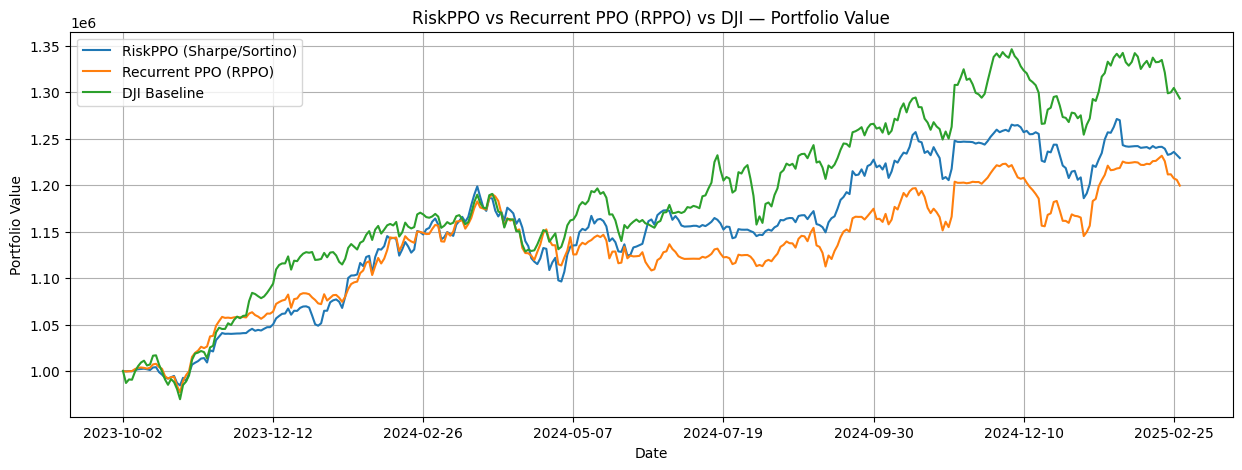

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Keep only RPPO-Risk and DJI
plot_df = merged_results_df[["rppo_risk", "dji"]].copy()
plot_df.columns = ["RPPO-Risk (LSTM + Sharpe)", "DJI Baseline"]

# Forward-fill any missing values
plot_df = plot_df.sort_index().ffill()

plt.figure(figsize=(15, 5))
plot_df.plot(ax=plt.gca())
plt.title("RPPO-Risk vs DJI — Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
# Get final values
final_combined = merged_results_df['rppo_risk'].dropna().iloc[-1]
final_dji = merged_results_df['dji'].dropna().iloc[-1]

# Print results
print(f"Final Account Value (RPPO-Risk): {final_combined:,.2f}")
print(f"Final Account Value (DJI Baseline): {final_dji:,.2f}")

# Determine which is highest
final_values = {
    "RPPO-Risk (LSTM + Sharpe)": final_combined,
    "DJI Baseline": final_dji
}
best_strategy = max(final_values, key=final_values.get)
print(f"\nThe best performing strategy is: **{best_strategy}** with a final value of {final_values[best_strategy]:,.2f}")


Final Account Value (RiskPPO): 1,229,251.53
Final Account Value (Recurrent PPO - RPPO): 1,199,596.92
Final Account Value (DJI Baseline): 1,293,304.38

The best performing strategy is: **DJI Baseline** with a final value of 1,293,304.38
